## first level analysis pipeline using nipype

In [1]:
from os.path import join as opj
import json
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

201002-09:27:23,298 nipype.utils WARNING:
	 A newer version (1.5.1) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


### set up

In [2]:
experiment_dir = '/output'
output_dir = 'first_level'
working_dir = 'workingdir'

TR = 2. # TR of functional images

### specify nodes

In [3]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

### specify GLM contrasts

sanity check of high vs low pain

In [4]:
# condition names
condition_names = ['High','Low']

# contrasts
cont01 = ['average', 'T', condition_names, [.5, .5]]
cont02 = ['High',    'T', condition_names, [1, 0]]
cont03 = ['Low',     'T', condition_names, [0, 1]]
cont04 = ['High>Low','T', condition_names, [.5,-.5]]
cont05 = ['Low>High','T', condition_names, [-.5,.5]]

contrast_list = [cont01, cont02, cont03, cont04, cont05]

### specify GLM model

In [5]:
import pandas as pd
trialinfo = pd.read_csv('../data/fmri_behavioural.csv')
trialinfo.head(10)

,subject,session,trial,seq,rt,gen_p1g2,gen_p2g1,prob_pxl,prob_obs,obs_p1g2,obs_p2g1,obs_p1g1,obs_p2g2,obs_p1,obs_p2,obs_p,runtime
0,6,1,1,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.60
1,6,1,2,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.10
2,6,1,3,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.60
3,6,1,4,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.05
4,6,1,5,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.60
5,6,1,6,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.20
6,6,1,7,1,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.80
7,6,1,8,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.25
8,6,1,9,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.80
9,6,1,10,2,NaN,0.2,0.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.40


In [6]:
# construct df
# df_sj6 = trialinfo[(trialinfo['subject']==6) & (trialinfo['session']==1)]
df_sj6 = trialinfo[trialinfo['subject']==6]
sj_info = pd.DataFrame()
sj_info['onset'] = df_sj6['runtime']
sj_info['duration'] = 0.
sj_info['weight'] = 1.
trial_type = df_sj6['seq'].replace({1:'Low', 2:'High'})
sj_info['trial_type'] = trial_type
sj_info

,onset,duration,weight,trial_type
0,1.60,0.0,1.0,High
1,3.10,0.0,1.0,High
2,4.60,0.0,1.0,High
3,6.05,0.0,1.0,High
4,7.60,0.0,1.0,High
...,...,...,...,...
1295,475.45,0.0,1.0,Low
1296,476.85,0.0,1.0,Low
1297,478.30,0.0,1.0,High
1298,479.75,0.0,1.0,High


In [8]:
for group in sj_info.groupby('trial_type'):
    print(group)
    print("")

('High',        onset  duration  weight trial_type
0       1.60       0.0     1.0       High
1       3.10       0.0     1.0       High
2       4.60       0.0     1.0       High
3       6.05       0.0     1.0       High
4       7.60       0.0     1.0       High
...      ...       ...     ...        ...
1289  459.55       0.0     1.0       High
1290  461.10       0.0     1.0       High
1297  478.30       0.0     1.0       High
1298  479.75       0.0     1.0       High
1299  481.35       0.0     1.0       High

[667 rows x 4 columns])

('Low',        onset  duration  weight trial_type
6      10.80       0.0     1.0        Low
10     16.90       0.0     1.0        Low
16     25.90       0.0     1.0        Low
22     41.70       0.0     1.0        Low
24     44.80       0.0     1.0        Low
...      ...       ...     ...        ...
1292  464.10       0.0     1.0        Low
1293  465.65       0.0     1.0        Low
1294  467.05       0.0     1.0        Low
1295  475.45       0.0     1.0   

### specify helper function to read subject info

In [34]:
def construct_sj(trialinfo, subject_id, run_num):
    # construct df
    df_sj = trialinfo[(trialinfo['subject']==int(subject_id)) & (trialinfo['session']==int(run_num))]
    sj_info = pd.DataFrame()
    sj_info['onset'] = df_sj['runtime']
    sj_info['duration'] = 0.
    sj_info['weight'] = 1.
    trial_type = df_sj['seq'].replace({1:'Low', 2:'High'})
    sj_info['trial_type'] = trial_type
    return sj_info

In [10]:
alltrialinfo = pd.read_csv('../data/fmri_behavioural.csv')
print(construct_sj(alltrialinfo,6,1))

      onset  duration  weight trial_type
0      1.60       0.0     1.0       High
1      3.10       0.0     1.0       High
2      4.60       0.0     1.0       High
3      6.05       0.0     1.0       High
4      7.60       0.0     1.0       High
..      ...       ...     ...        ...
255  469.05       0.0     1.0       High
256  470.45       0.0     1.0        Low
257  471.85       0.0     1.0       High
258  473.40       0.0     1.0        Low
259  474.95       0.0     1.0        Low

[260 rows x 4 columns]


In [29]:
!pwd

/tsl_data/imaging


In [48]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    def construct_sj(trialinfo, subject_id, run_num):
        # construct df
        df_sj = trialinfo[(trialinfo['subject']==int(subject_id)) & (trialinfo['session']==int(run_num))]
        sj_info = pd.DataFrame()
        sj_info['onset'] = df_sj['runtime']
        sj_info['duration'] = 0.
        sj_info['weight'] = 1.
        trial_type = df_sj['seq'].replace({1:'Low', 2:'High'})
        sj_info['trial_type'] = trial_type
        return sj_info

    subject_info = []
    
    alltrialinfo = pd.read_csv('/tsl_data/data/fmri_behavioural.csv')
    alltrialinfo.head()
    
#     for run in range(1,2+1):
    run = 1
    trialinfo = construct_sj(alltrialinfo, subject_id, run)
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset))# - 10)) # subtracting 10s due to removing of 4 dummy scans
        durations.append(group[1].duration.tolist())

#         subject_info.insert(run, 
    subject_info = [Bunch(conditions=conditions,
                              onsets=onsets,
                              durations=durations,
                              #amplitudes=None,
                              #tmod=None,
                              #pmod=None,
                              #regressor_names=None,
                              #regressors=None
                             )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [37]:
# subjectinfo(6)

### specify input and output

In [46]:
!ls /data/sub-06/func

sub-06_task-tsl_run-1_desc-confounds_regressors.json
sub-06_task-tsl_run-1_desc-confounds_regressors.tsv
sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_boldref.nii.gz
sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.json
sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.json
sub-06_task-tsl_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-06_task-tsl_run-2_desc-confounds_regressors.json
sub-06_task-tsl_run-2_desc-confounds_regressors.tsv
sub-06_task-tsl_run-2_space-MNI152NLin2009cAsym_boldref.nii.gz
sub-06_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.json
sub-06_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz
sub-06_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.json
sub-06_task-tsl_run-2_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
sub-06_task-tsl_run-3_desc-confounds_regressors.json
sub-06_task-tsl_run-3_desc-confounds_regres

In [56]:
tmp = '/data/sub-06/func/sub-06_task-tsl_run-1_desc-confounds_regressors.tsv'
dfff = pd.read_csv(tmp, delimiter='\t')

In [62]:
dfff.shape

(246, 245)

In [49]:
# docker dirs
smooth_dir = '/output/smooth/preproc'
data_dir = '/data'

# test subject and run
subject_list = ['06']
run_list = ['1']
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'run_num',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('run_num', run_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
# templates = {'func': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
#                          'fwhm-{fwhm_id}_ssub-{subject_id}_ses-test_task-{task_id}_bold.nii'),
#              'mc_param': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
#                              'sub-{subject_id}_ses-test_task-{task_id}_bold.par'),
#              'outliers': opj(output_dir, 'preproc', 'sub-{subject_id}', 'task-{task_id}',
#                              'art.sub-{subject_id}_ses-test_task-{task_id}_bold_outliers.txt')}
templates = {'func': opj(smooth_dir, 'sub-{subject_id}',
                         'sub-{subject_id}_task-tsl_run-{run_num}_fwhm-8_bold.nii')}
#              ,
#              'mc_param': opj(data_dir, 'sub-{subject_id}', 'func',
#                              'sub-{subject_id}_task-tsl_run-{run_num}_desc-confounds_regressors.tsv')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
# selectfiles.inputs.task_id = 'fingerfootlips'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
substitutions += [('_run_num_%s' % r, '') for r in run_list]
# subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s/fwhm-%s' % (sub, f))
#                for f in fwhm
#                for sub in subject_list]
# substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

### specify workflow

In [50]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('run_num', 'run_num')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
#                     (selectfiles, modelspec, [('mc_param', 'realignment_parameters'),
#                                               ('outliers', 'outlier_files')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, datasink, [('spm_mat_file', '1stLevel.@spm_mat'),
                                              ('spmT_images', '1stLevel.@T'),
                                              ('con_images', '1stLevel.@con'),
                                              ('spmF_images', '1stLevel.@F'),
                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    ])

### run workflow

In [51]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

201002-09:40:05,330 nipype.workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging', 'monitoring']
201002-09:40:05,348 nipype.workflow INFO:
	 Running in parallel.
201002-09:40:05,353 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB): 14.07/14.07, Free processors: 4/4.
201002-09:40:05,463 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.getsubjectinfo" in "/output/workingdir/l1analysis/_run_num_1_subject_id_06/getsubjectinfo".201002-09:40:05,464 nipype.workflow INFO:
	 [Node] Setting-up "l1analysis.selectfiles" in "/output/workingdir/l1analysis/_run_num_1_subject_id_06/selectfiles".

201002-09:40:05,474 nipype.workflow INFO:
	 [Node] Running "getsubjectinfo" ("nipype.interfaces.utility.wrappers.Function")201002-09:40:05,476 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")

201002-09:40:05,492 nipype.workflow INFO:
	 [Node] Finished "l1analysis.selectfiles".
201002-09:40:05,564 nip

### visualise design matrix

In [52]:
import numpy as np
from matplotlib import pyplot as plt

In [53]:
from scipy.io import loadmat

# Using scipy's loadmat function we can access SPM.mat
spmmat = loadmat('/output/first_level/1stLevel/sub-06/SPM.mat',
                 struct_as_record=False)

In [54]:
designMatrix = spmmat['SPM'][0][0].xX[0][0].X
names = [i[0] for i in spmmat['SPM'][0][0].xX[0][0].name[0]]
normed_design = designMatrix / np.abs(designMatrix).max(axis=0)

In [56]:
normed_design.shape

(242, 5)

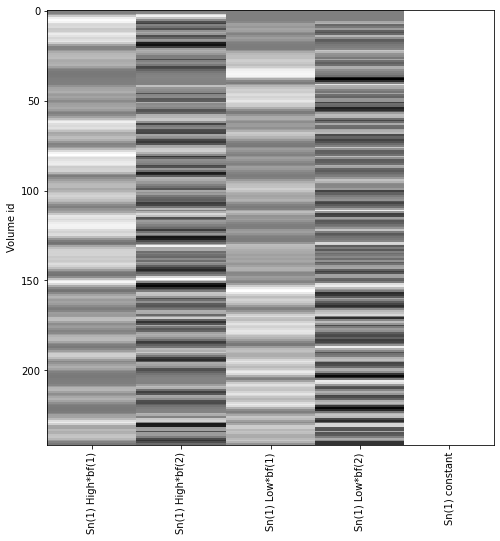

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(normed_design, aspect='auto', cmap='gray', interpolation='none')
ax.set_ylabel('Volume id')
ax.set_xticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=90);

### visualise results

In [58]:
from nilearn.plotting import plot_stat_map
anatimg = '/data/sub-06/anat/sub-06_desc-preproc_T1w.nii.gz'

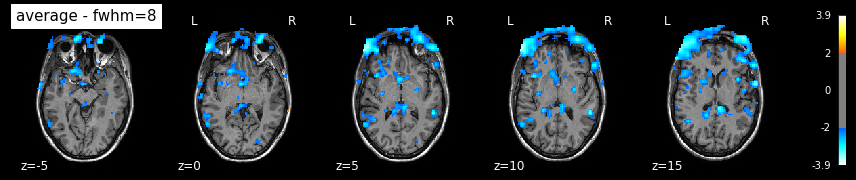

In [63]:
plot_stat_map(
    '/output/first_level/1stLevel/sub-06/spmT_0004.nii', title='average - fwhm=8',
    bg_img=anatimg, threshold=2, display_mode='z', cut_coords=(-5, 0, 5, 10, 15), dim=-1);

### visualise workflow

201002-09:32:11,91 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.png (graph2use=colored, simple_form=True).


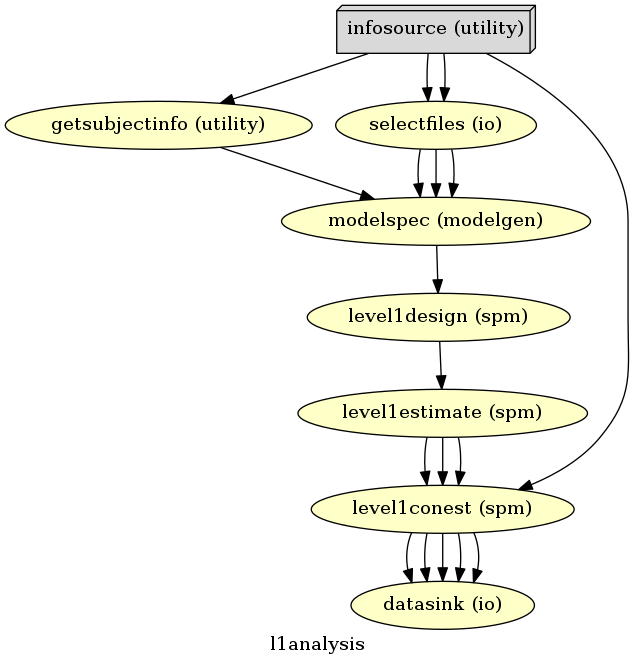

In [25]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.png'))